# Plot utilities

> A set of convenience functions for plotting code

In [1]:
#| default_exp plot_utils

In [2]:
#| export

from gh_pages_example.model_utils import *
from gh_pages_example.utils import *

import fastcore.test
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from nbdev.showdoc import *
import nptyping
import numpy as np
import pandas
import plotly.graph_objects as go
import plotly.io as io

/home/ethos/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):


## Utilities from the Open Source Community

### NayanSaran/markov-chain

Here are classes for drawing markov chain diagrams.

I have modified to code for:
- greater flexibility in choosing the colours of the nodes.

Credit: Naysan Saran Modification: [M Shaf Khattak].(https://github.com/SHaf373)

License

This project is licensed under the GPL V3 licence.

In [3]:
#| export
"""Credit: Naysan Saran Modification: [M Shaf Khattak].(https://github.com/SHaf373)

License

This project is licensed under the GPL V3 licence."""

class Node():

    def __init__(
        self, center, radius, label,
        facecolor='#2653de', edgecolor='#e6e6e6',
        ring_facecolor='#a3a3a3', ring_edgecolor='#a3a3a3',
        **kwargs
        ):
        """
        Initializes a Markov Chain Node(for drawing purposes)
        Inputs:
            - center : Node (x,y) center
            - radius : Node radius
            - label  : Node label
        """
        self.center = center
        self.radius = radius
        self.label  = label

        # For convinience: x, y coordinates of the center
        self.x = center[0]
        self.y = center[1]

        # Drawing config
        self.node_facecolor = facecolor
        self.node_edgecolor = edgecolor

        self.ring_facecolor = ring_facecolor
        self.ring_edgecolor = ring_edgecolor
        self.ring_width = 0.03

        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': kwargs.get("node_fontsize", 12)
        }


    def add_circle(self, ax):
        """
        Add the annotated circle for the node
        """
        circle = mpatches.Circle(self.center, self.radius)
        p = PatchCollection(
            [circle],
            edgecolor = self.node_edgecolor,
            facecolor = self.node_facecolor
        )
        ax.add_collection(p)
        ax.annotate(
            self.label,
            xy = self.center,
            color = '#ffffff',
            **self.text_args
        )


    def add_self_loop(self, ax, prob=None, direction='up', annotate = True, percentages = False):
        """
        Draws a self loop
        """
        if direction == 'up':
            start = -30
            angle = 180
            ring_x = self.x
            ring_y = self.y + self.radius
            prob_y = self.y + 1.3*self.radius
            x_cent = ring_x - self.radius + (self.ring_width/2)
            y_cent = ring_y - 0.15
        else:
            start = -210
            angle = 0
            ring_x = self.x
            ring_y = self.y - self.radius
            prob_y = self.y - 1.4*self.radius
            x_cent = ring_x + self.radius - (self.ring_width/2)
            y_cent = ring_y + 0.15

        # Add the ring
        ring = mpatches.Wedge(
            (ring_x, ring_y),
            self.radius,
            start,
            angle,
            width = self.ring_width
        )
        # Add the triangle (arrow)
        offset = 0.2
        left   = [x_cent - offset, ring_y]
        right  = [x_cent + offset, ring_y]
        bottom = [(left[0]+right[0])/2., y_cent]
        arrow  = plt.Polygon([left, right, bottom, left])

        p = PatchCollection(
            [ring, arrow],
            edgecolor = self.ring_edgecolor,
            facecolor = self.ring_facecolor
        )
        ax.add_collection(p)

        # Probability to add?
        if prob and annotate:
            text = f"{prob*100 if percentages else prob:.1f}".rstrip("0").rstrip(".")
            text += "%" if percentages else ""
            ax.annotate(text, xy=(self.x, prob_y), color='#000000', **self.text_args)


In [4]:
# | export
"""Credit: Naysan Saran Modification: [M Shaf Khattak].(https://github.com/SHaf373)

License

This project is licensed under the GPL V3 licence."""


class MarkovChain:

    def __init__(self, M, labels, **kwargs):
        """
        Initializes a Markov Chain (for drawing purposes)
        Inputs:
            - M         Transition Matrix
            - labels    State Labels
            - kwargs    Keywords to modify how data is displayed, specifically:
                        annotate          if False, probabilities aren't shown
                        arrow_edgecolor
                        arrow_facecolor
                        arrow_head_width
                        arrow_width
                        fontsize          affects transition probability labels
                        node_edgecolor
                        node_facecolor
                        node_fontsize     affects node labels
                        node_radius
                        percentages       bool, if True probabilites should be
                                          displayed as percentages instead of decimals
                        transparency_func function to determine transparency of arrows (default: alpha = prob)
        """

        np.set_printoptions(precision=3, suppress=True)

        if M.shape[0] < 2:
            raise Exception("There should be at least 2 states")
        if M.shape[0] != M.shape[1]:
            raise Exception("Transition matrix should be square")
        if M.shape[0] != len(labels):
            raise Exception("There should be as many labels as states")

        # save args
        self.M = M
        self.n_states = M.shape[0]
        self.labels = labels

        self.save_kwargs(**kwargs)

        # Build the network
        self.build_network()

    def save_kwargs(self, **kwargs):

        # save the dictionary
        self.kwargs = kwargs

        # Colors
        self.arrow_facecolor = self.kwargs.get("arrow_facecolor", '#a3a3a3')
        self.arrow_edgecolor = self.kwargs.get("arrow_edgecolor", '#a3a3a3')
        self.node_facecolor = self.kwargs.get("node_facecolor", '#2693de')
        self.node_edgecolor = self.kwargs.get("node_edgecolor", '#e6e6e6')

        # Drawing config
        self.node_radius = self.kwargs.get("node_radius", 0.60)
        self.arrow_width = self.kwargs.get("arrow_width", 0.1)
        self.arrow_head_width = self.kwargs.get("arrow_head_width", 0.22)
        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': self.kwargs.get("fontsize", 14)
        }
        self.scale_xlim = self.kwargs.get("scale_xlim", 1)
        self.scale_ylim = self.kwargs.get("scale_ylim", 1)

        # How to represent the probabilities
        self.percentages = self.kwargs.get("percentages", False)
        self.annotate_probabilities = self.kwargs.get("annotate", True)
        self.transparency_func = self.kwargs.get(
            "transparency_func", lambda p: p)

        # Additional config options
        self.self_arrows = self.kwargs.get("self_arrows", True)
        self.n_columns = self.kwargs.get('n_columns')

    def set_node_centers(self):
        """
            Spread the nodes evenly around in a circle using Euler's formula
            e^(2pi*i*k/n), where n is the number of nodes and k is the
            index over which we iterate. The real part is the x coordinate,
            the imaginary part is the y coordinate. Then scale by n for more room.

            self.node_centers is a numpy array of shape (n,2)
        """

        # For legibility, we use n below
        n = self.n_states

        # generate the evenly spaced coords on the unit circle
        unit_circle_coords = np.fromfunction(lambda x, y:
                                             (1-y)*np.real(np.exp(2 * np.pi * x/n * 1j))
                                             + y *
                                             np.imag(
                                                 np.exp(2 * np.pi * x/n * 1j)),
                                             (n, 2))

        self.figsize = (n*2+2, n*2+2)
        self.xlim = (-n-1, n+1)
        self.ylim = (-n-1, n+1)
        self.xlim = tuple([self.scale_xlim * l for l in self.xlim])
        self.ylim = tuple([self.scale_ylim * l for l in self.ylim])

        # Scale by n to have more room
        self.node_centers = unit_circle_coords * n

        # For legibility, we use n below
        n = self.n_states

        # generate the evenly spaced coords on the unit grid with n_columns
        n_columns = self.n_columns
        n_rows = n // n_columns
        grid_coords = np.vstack([[x - n_columns/4, n_rows - 1 - y]
                                 for x in range(n_columns)
                                 for y in range(n_rows)])

        self.figsize = (n*2+4, n*2+4)
        self.xlim = (-1*(n+2), n+2)
        self.ylim = (-2, n*2+2)
        self.xlim = tuple([self.scale_xlim * l for l in self.xlim])
        self.ylim = tuple([self.scale_ylim * l for l in self.ylim])

        # Scale by n to have more room
        self.node_centers = grid_coords * n

    def build_network(self):
        """
        Loops through the matrix, add the nodes
        """
        # Position the node centers
        self.set_node_centers()

        # Set the nodes
        self.nodes = [Node(self.node_centers[i],
                           self.node_radius,
                           self.labels[i],
                           **{**self.kwargs,
                              "facecolor": (self.node_facecolor
                                            if isinstance(self.node_facecolor,
                                                          str)
                                            else self.node_facecolor[i])
                              }
                           )
                      for i in range(self.n_states)]

    def add_arrow(self, ax,
                  node1, node2,
                  prob=None, width=None,
                  head_width=None,
                  annotate=True,
                  arrow_spacing=0.15,
                  transparency_func=None):
        """
        Add a directed arrow between two nodes

        Keywords:

        annotate:                if True, probability is displayed on top of the arrow
        arrow_spacing:           determines space between arrows in opposite directions
        head_width:              width of arrow head
        prob:                    probability of going from node1 to node2
        transparency_func:       function to determine transparency of arrows
        width:                   width of arrow body
        """

        if width is None:
            width = self.arrow_width
        if head_width is None:
            head_width = self.arrow_head_width
        if transparency_func is None:
            transparency_func = self.transparency_func

        # x,y start of the arrow, just touching the starting node
        x_start = node1.x + node1.radius * \
            (node2.x-node1.x)/np.linalg.norm(node2.center-node1.center)
        y_start = node1.y + node1.radius * \
            (node2.y-node1.y)/np.linalg.norm(node2.center-node1.center)

        # find the arrow length so it just touches the ending node
        dx = node2.x-x_start - node2.radius * \
            (node2.x-node1.x)/np.linalg.norm(node2.center-node1.center)
        dy = node2.y-y_start - node2.radius * \
            (node2.y-node1.y)/np.linalg.norm(node2.center-node1.center)

        # calculate offset so arrows in opposite directions are separate

        x_offset = dy / np.sqrt(dx**2+dy**2) * arrow_spacing
        y_offset = -dx / np.sqrt(dx**2+dy**2) * arrow_spacing

        arrow = mpatches.FancyArrow(
            x_start + x_offset,
            y_start + y_offset,
            dx,
            dy,
            width=width,
            head_width=head_width,
            length_includes_head=True
        )

        # Check if arrow overlaps any other nodes on the way
        # Use curved arrow instead
        if ((node1.x == node2.x) and
            np.any([((center[0] == node1.x)
                     and (((center[1] > node1.y)
                           and (center[1] < node2.y))
                          or ((center[1] < node1.y)
                              and (center[1] > node2.y))))
                    for center in self.node_centers])):
            style=mpatches.ArrowStyle('simple',
                                      head_length=2*head_width,
                                      head_width=head_width,
                                      tail_width=width)
            arrow = mpatches.FancyArrowPatch(
                
                posA=(x_start + x_offset, y_start + y_offset),
                posB=(x_start + x_offset + dx, y_start + y_offset + dy),
                shrinkA=0, shrinkB=0,
                arrowstyle=style,
                mutation_scale=1,
                connectionstyle="arc3, rad=0.4")
            arrow.set_linewidth(0.2)

        
        p = PatchCollection(
            [arrow],
            edgecolor=self.arrow_edgecolor,
            facecolor=self.arrow_facecolor,
            alpha=transparency_func(prob)
        )
        ax.add_collection(p)

        # Add label of probability at coordinates (x_prob, y_prob)
        x_prob = x_start + 0.2*dx + 1.2 * x_offset
        y_prob = y_start + 0.2*dy + 1.2 * y_offset
        if prob and annotate:
            text = f"{prob*100 if self.percentages else prob:.1f}".rstrip(
                "0").rstrip(".")
            text += "%" if self.percentages else ""
            ax.annotate(text, xy=(x_prob, y_prob),
                        color='#000000', **self.text_args)

    def draw(self, img_path=None):
        """
        Draw the Markov Chain
        """
        fig, ax = plt.subplots(figsize=self.figsize)

        # Set the axis limits
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)

        # Draw the nodes
        for node in self.nodes:
            node.add_circle(ax)

        # Add the transitions
        for i in range(self.M.shape[0]):
            for j in range(self.M.shape[1]):
                # self loops
                if self.self_arrows and i == j and self.M[i, i] > 0:
                    self.nodes[i].add_self_loop(ax,
                                                prob=self.M[i, j],
                                                direction='up' if self.nodes[i].y >= 0 else 'down',
                                                annotate=self.annotate_probabilities,
                                                percentages=self.percentages)

                # directed arrows
                elif self.M[i, j] > 0 and i!=j:
                    self.add_arrow(ax,
                                   self.nodes[i],
                                   self.nodes[j],
                                   prob=self.M[i, j],
                                   annotate=self.annotate_probabilities)

        plt.axis('off')
        # Save the image to disk?
        if img_path:
            plt.savefig(img_path)
        plt.show()


Let's quickly test that the above code works in this notebook.

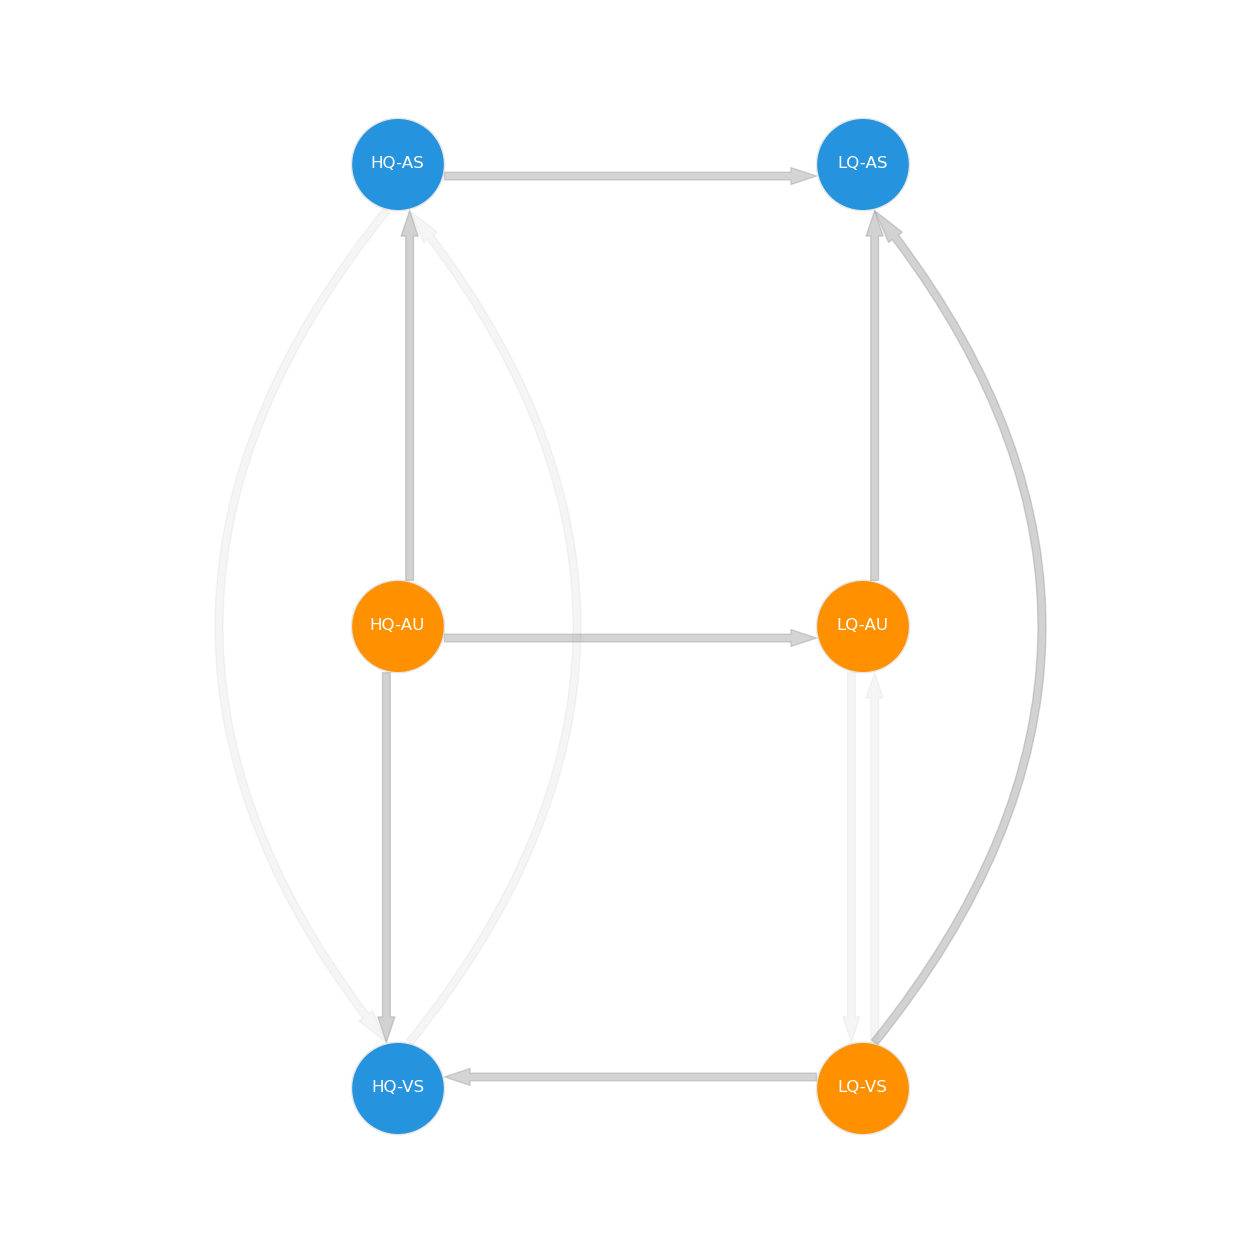

In [5]:
P = np.array([[0.7826, 0., 0.0067, 0.2107, 0., 0.],
              [0.2349, 0.3195, 0.2349, 0., 0.2107, 0.],
              [0.0067, 0., 0.9933, 0., 0., 0.],
              [0., 0., 0., 1., 0., 0.],
              [0., 0., 0., 0.2349, 0.7584, 0.0067],
              [0., 0., 0.2107, 0.2349, 0.0067, 0.5477]])
# P = np.where(P < 0.01, 0, P)
mc = MarkovChain(P,
                 ['HQ-AS', 'HQ-AU', 'HQ-VS', 'LQ-AS', 'LQ-AU', 'LQ-VS'],
                 percentages=True,
                 self_arrows=False,
                 annotate=False,
                 n_columns=2,
                 node_facecolor= ["#2693de", "#ff9000", "#2693de",
                                  "#2693de", "#ff9000", "#ff9000"],
                 transparency_func=lambda p:max(p**0.5, 0.1))
mc.draw()

## My own utilities

In [6]:
#| export
def plot_strategy_distribution(data, # The dataset containing data on parameters and the strategy distribution
                               strategy_set, # The strategies to plot from the dataset
                               x="pr", # The parameter to place on the x-axis of the plot
                               x_label='Risk of an AI disaster, pr', # the x-axis label
                               title='Strategy distribution', # the plot title
                               thresholds=["threshold_society_prefers_safety",
                                           "threshold_risk_dominant_safety"], # A list of threshold names in data
                               cmap=plt.colormaps["tab10"],
                               ) -> None:
    """Plot the strategy distribution as we vary `x`."""

    fig, ax = plt.subplots()
    ax.stackplot(data[x],
                 [data[strategy + "_frequency"] for strategy in strategy_set],
                 labels=strategy_set,
                 colors=[cmap(i) for i in range(cmap.N)],
                 alpha=0.8)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel('Proportion')

    # Add threshold boundaries to convey dilemma region
    if thresholds!=None:        
        plt.vlines([data[name].values[0] for name in thresholds],
                    0,
                    0.995,
                    colors=[f"C{2+i}" for i in range(len(thresholds))],
                    linewidth=3)

In [7]:
#| export
def plot_heatmap(table, # A pivot table, created using `pandas.pivot` function
                 figure_object=None,
                 xlabel="x",
                 ylabel="y",
                 zlabel="z",
                 cmap='inferno',
                 zmin=0,
                 zmax=1,
                 zcenter=None,
                 norm=None,
                 interpolation=None,
                 set_colorbar=True,
                 set_labels=True,
                ):
    """Plot heatmap using the index, columns, and values from `table`."""
    if figure_object==None:
        heatmap, ax = plt.subplots()
    else:
        heatmap, ax = figure_object
    im = ax.imshow(table.values,
                   cmap=cmap,
                   norm=norm,
                   extent=[table.columns.min(),
                           table.columns.max(),
                           table.index.min(),
                           table.index.max()],
                   vmin=zmin,
                   vmax=zmax,
                   interpolation=interpolation,
                   origin='lower',
                   aspect='auto')
    if set_labels:
        ax.set(xlabel=xlabel,
            ylabel=ylabel)
    if set_colorbar:
        cbar = heatmap.colorbar(im)
        cbar.ax.set_ylabel(zlabel)
    return heatmap, ax, im

3D quiver plot

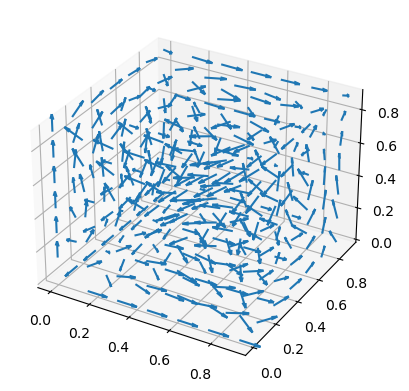

In [8]:
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
x, y, z = np.meshgrid(np.arange(0, 1, 0.15),
                      np.arange(0, 1, 0.15),
                      np.arange(0, 1, 0.15))

# Make the direction data for the arrows
u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
     np.sin(np.pi * z))

ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True)
plt.show()

In [9]:
df = pandas.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/vortex.csv")

fig = go.Figure(data = go.Cone(
    x=df['x'],
    y=df['y'],
    z=df['z'],
    u=df['u'],
    v=df['v'],
    w=df['w'],
    colorscale='Blues',
    sizemode="absolute",
    sizeref=40))

fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=0.8),
                             camera_eye=dict(x=1.2, y=1.2, z=0.6)))

fig.show()

In [10]:
def payoffs_encanacao_2016(models):
    names = ['b_r', 'b_s', 'c_s', 'c_t', 'σ']
    b_r, b_s, c_s, c_t, σ = [models[k] for k in names]
    payoffs = {}
    n_players = 3
    n_sectors = 3
    n_strategies_per_sector = [2, 2, 2]
    n_strategies_total = 6
    index_min = "0-0-0" # All players are from the first sector, playing that sector's first strategy
    index_max = "5-5-5" # All players are from the third sector, playing that sector's second strategy
    # Note: The seperator makes it easy to represent games where n_strategies_total >= 10.
    
    # It is also trivial to define a vector which maps these indexes to strategy profiles
    # As sector order is fixed we could neglect to mention suscripts for each sector
    strategy_names = ["D", "C", "D", "C", "D", "C"]
    
    zero = np.zeros(b_r.shape[0])
    # As in the main text
    payoffs["C-C-C"] = {"P3": b_r-2*c_s,
                        "P2": σ+b_s-c_t,
                        "P1": σ+b_s}
    payoffs["C-C-D"] = {"P3": -c_s,
                        "P2": b_s-c_t,
                        "P1": zero}
    payoffs["C-D-C"] = {"P3": b_r-c_s,
                        "P2": zero,
                        "P1": b_s}
    payoffs["C-D-D"] = {"P3": zero,
                        "P2": σ,
                        "P1": σ}
    payoffs["D-C-C"] = {"P3": zero,
                        "P2": σ-c_t,
                        "P1": σ}
    payoffs["D-C-D"] = {"P3": zero,
                        "P2": -c_t,
                        "P1": zero}
    payoffs["D-D-C"] = {"P3": zero,
                        "P2": zero,
                        "P1": zero}
    payoffs["D-D-D"] = {"P3": zero,
                        "P2": σ,
                        "P1": σ}
    
    # The following indexes capture all strategy profiles where each player is fixed to a unique sector
    # (and player order does not matter, so we need only consider one ordering of sectors).
    payoffs["4-2-0"] = payoffs["D-D-D"]
    payoffs["4-2-1"] = payoffs["D-D-C"]
    payoffs["4-3-0"] = payoffs["D-C-D"]
    payoffs["4-3-1"] = payoffs["D-C-C"]
    payoffs["5-2-0"] = payoffs["C-D-D"]
    payoffs["5-2-1"] = payoffs["C-D-C"]
    payoffs["5-3-0"] = payoffs["C-C-D"]
    payoffs["5-3-1"] = payoffs["C-C-C"]
    return {**models, "payoffs": payoffs}

In [11]:
def sample_profile_gos(models):
    """We sample players from their allowed sectors as per the sector weights."""
    sector_strategies = models['sector_strategies']
    allowed_sectors = models['allowed_sectors']
    profile = models['profile']
    chosen_player = models['chosen_player']
    chosen_strategy = int(models['chosen_strategy'])
    current_strategy = int(models['current_strategy'])
    mutant_strategy = int(models['mutant_strategy'])
    affected_sector = models['affected_sector']
    n_mutants = models['n_mutants']
    Z = models['Z']
    sector_weights = models.get('sector_weights', {})
    assert n_mutants >= 1
    assert n_mutants <= Z[affected_sector] - 1
    assert current_strategy != mutant_strategy
    assert chosen_strategy in [current_strategy, mutant_strategy]
    assert affected_sector in sector_strategies.keys()
    assert chosen_player in allowed_sectors.keys()

    profile_tuple = list(map(int, profile.split("-")))
    assert chosen_strategy in profile_tuple

    # TODO: does it make sense for chosen_player_likelihood to take into account
    # any possible position our chosen_player could have been in, no matter
    # which strategies each player actually plays in the profile?
    above = sector_weights.get(chosen_player, {}).get(affected_sector, 1)
    below = 0
    for player, sectors in allowed_sectors.items():
        if affected_sector in sectors:
            below += sector_weights.get(player, {}).get(affected_sector, 1)
    if below == 0:
        raise ValueError("""affected_sector is never allowed in the game, 
                         double check allowed_sectors""")
    # print("chosen_player_likelihood: ", above / below)
    chosen_player_likelihood = above / below

    likelihood = chosen_player_likelihood

    n_sampled_from_affected_sector = 1
    n_mutants_sampled = 1 if chosen_strategy == mutant_strategy else 0
    for i, strategy in enumerate(profile_tuple[::-1]):
        strategy = int(strategy)  #coerce to integer
        valid_strategy = False
        for sector in allowed_sectors[f"P{i+1}"]:
            if strategy in sector_strategies[sector]:
                valid_strategy = True
        if not valid_strategy:
            raise ValueError("""Profile implies a player plays a strategy from
                             a sector they do not belong to.""")
        if f"P{i+1}" == chosen_player:
            continue
        if strategy in sector_strategies[affected_sector]:
            if strategy == current_strategy:
                likelihood *= ((Z[affected_sector]
                                - (n_sampled_from_affected_sector
                                   - n_mutants_sampled)
                                - n_mutants)
                               / (Z[affected_sector]
                                  - n_sampled_from_affected_sector))
                # print("current-lk: ",
                #       (Z[affected_sector]
                #        - (n_sampled_from_affected_sector - n_mutants_sampled)
                #        - n_mutants),
                #       "/",
                #       (Z[affected_sector] - n_sampled_from_affected_sector))
                n_sampled_from_affected_sector += 1
            elif strategy == mutant_strategy:
                likelihood *= ((n_mutants
                                - n_mutants_sampled)
                               / (Z[affected_sector]
                                  - n_sampled_from_affected_sector))
                # print("mutant-lk: ",
                #       (n_mutants - n_mutants_sampled),
                #       "/",
                #       (Z[affected_sector] - n_sampled_from_affected_sector))
                n_mutants_sampled += 1
                n_sampled_from_affected_sector += 1
            else:
                raise ValueError("""At least one profile implies the copresence
                                 of 3 strategies for one sector. This default
                                 profile likelihood method is not meant to be
                                 used for such situations. Make sure you use
                                 profile filters to prevent passing such
                                 strategy profiles to this sampling rule.""")
        relevant_sector = [sector
                           for sector in sector_strategies.keys()
                           if strategy in sector_strategies[sector]]
        if len(relevant_sector) > 1:
            raise ValueError("Each sector must have unique strategy codes")
        elif len(relevant_sector) == 0:
            raise ValueError("Strategy does not belong to any sector")
        else:
            relevant_sector = relevant_sector[0]
        above = sector_weights.get("P{i+1}", {}).get(relevant_sector, 1)
        below = sum(sector_weights.get("P{i+1}", {}).get(sector, 1)
                    for sector in allowed_sectors[f"P{i+1}"])
        likelihood *= above / below
        # print("relevant_sector_likelihood: ", above / below)
    return likelihood

def compute_success_gos(models):
    success = 0
    return success


def compute_gos(models):
    payoffs = models['payoffs']
    current_state = models['current_state']
    Z = models['Z']
    β = models['β']
    μ = models['μ']
    sector_strategies = models['sector_strategies']
    strategy_set = np.unique([s
                              for s in strategies
                              for strategies in sector_strategies.keys()])
    fitness = {strategy: compute_success({**models,
                                          "strategy": strategy,
                                          "compute_success_rule": "current_state"})
               for strategy, _ in enumerate(strategy_set)}
    gos = {}
    all_gos = {}
    for sector, strategies in sector_strategies:
        gradients = {}
        for s1 in strategies:
            for s2 in strategies:
                x = current_state[s1]
                y = current_state[s2]
                gradient = (np.tanh(β
                                    * (fitness[s1]
                                       - fitness[s2])
                                    / 2)
                            * y
                            * x
                            + μ * (1 - x - y))
                gradients[f"{s1}-{s2}"] =gradient
        gradient_max = np.max(list(gradients.keys()))
        gos[sector] = gradient_max
        all_gos[sector] = gradients
    return {**models, "gos": gos, "all_gos": all_gos}


In [12]:
def gos_encanacao_2016(models):
    payoffs = models['payoffs']
    x,y,z = models['current_state']
    Z1, Z2, Z3 = models['Z']
    β = models['β']
    μ = models['μ']
    fitness_C1 = (y*z*payoffs["C-C-C"]["P1"]
                  + (1-y)*z*payoffs["C-D-C"]["P1"]
                  + y*(1-z)*payoffs["D-C-C"]["P1"]
                  + (1-y)*(1-z)*payoffs["D-D-C"]["P1"])
    fitness_D1 = (y*z*payoffs["C-C-D"]["P1"]
                  + (1-y)*z*payoffs["D-D-D"]["P1"]
                  + y*(1-z)*payoffs["D-C-D"]["P1"]
                  + (1-y)*(1-z)*payoffs["D-D-D"]["P1"])
    fitness_C2 = (x*z*payoffs["C-C-C"]["P2"]
                  + (1-x)*z*payoffs["C-C-D"]["P2"]
                  + x*(1-z)*payoffs["D-C-C"]["P2"]
                  + (1-x)*(1-z)*payoffs["D-C-D"]["P2"])
    fitness_D2 = (x*z*payoffs["C-D-C"]["P2"]
                  + (1-x)*z*payoffs["C-D-D"]["P2"]
                  + x*(1-z)*payoffs["D-D-C"]["P2"]
                  + (1-x)*(1-z)*payoffs["D-D-D"]["P2"]) 
    fitness_C3 = (x*y*payoffs["C-C-C"]["P3"]
                  + (1-x)*y*payoffs["C-C-D"]["P3"]
                  + x*(1-y)*payoffs["C-D-C"]["P3"]
                  + (1-x)*(1-y)*payoffs["C-D-D"]["P3"])
    fitness_D3 = (x*y*payoffs["D-C-C"]["P3"]
                  + (1-x)*y*payoffs["D-C-D"]["P3"]
                  + x*(1-y)*payoffs["D-D-C"]["P3"]
                  + (1-x)*(1-y)*payoffs["D-D-D"]["P3"])
    
    g1 = (np.tanh(β*(fitness_C1 - fitness_D1)/2) * (1 - x) * x
          + μ * (1 - 2*x))
    g2 = (np.tanh(β*(fitness_C2 - fitness_D2)/2) * (1 - y) * y
          + μ * (1 - 2*y))
    g3 = (np.tanh(β*(fitness_C3 - fitness_D3)/2) * (1 - z) * z
          + μ * (1 - 2*z))
    models['u'] = g1
    models['v'] = g2
    models['w'] = g3
    models['gos'] = [g1, g2, g3]
    return models
    

In [13]:
models = model_builder({"b_r": 0.8,
               "b_s": 0.4,
               "c_s": 0.15,
               "c_t": 0.15,
               "σ": 0.2,
               "x": np.arange(0, 1, 0.2),
               "y": np.arange(0, 1, 0.2),
               "z": np.arange(0, 1, 0.2),})
models['current_state'] = [models['x'], models['y'], models['z']]
models = {**models, "Z": [50, 50, 50], "β": 2.5, "μ": 0.02}

In [14]:
results =  thread_macro(models,
                        payoffs_encanacao_2016,
                        gos_encanacao_2016,
                       )

In [15]:
results['gos']

[array([ 0.02 ,  0.02 ,  0.02 ,  0.02 ,  0.02 ,  0.02 ,  0.02 ,  0.02 ,
         0.02 ,  0.02 ,  0.02 ,  0.02 ,  0.02 ,  0.02 ,  0.02 ,  0.02 ,
         0.02 ,  0.02 ,  0.02 ,  0.02 ,  0.02 ,  0.02 ,  0.02 ,  0.02 ,
         0.02 , -0.027, -0.012,  0.004,  0.02 ,  0.036, -0.012,  0.004,
         0.02 ,  0.036,  0.051,  0.004,  0.02 ,  0.036,  0.051,  0.066,
         0.02 ,  0.036,  0.051,  0.066,  0.08 ,  0.036,  0.051,  0.066,
         0.08 ,  0.092, -0.055, -0.032, -0.008,  0.016,  0.04 , -0.032,
        -0.008,  0.016,  0.04 ,  0.063, -0.008,  0.016,  0.04 ,  0.063,
         0.085,  0.016,  0.04 ,  0.063,  0.085,  0.105,  0.04 ,  0.063,
         0.085,  0.105,  0.124, -0.063, -0.04 , -0.016,  0.008,  0.032,
        -0.04 , -0.016,  0.008,  0.032,  0.055, -0.016,  0.008,  0.032,
         0.055,  0.077,  0.008,  0.032,  0.055,  0.077,  0.097,  0.032,
         0.055,  0.077,  0.097,  0.116, -0.051, -0.036, -0.02 , -0.004,
         0.012, -0.036, -0.02 , -0.004,  0.012,  0.027, -0.02 , 

In [16]:
np.arange(0, 1, 0.2)

array([0. , 0.2, 0.4, 0.6, 0.8])

In [17]:
fig = go.Figure(data = go.Cone(
    x=results['x'],
    y=results['y'],
    z=results['z'],
    u=results['u'],
    v=results['v'],
    w=results['w'],
    # colorscale='Reds',
    # sizemode="absolute",
    # sizeref=40
))

fig.update_layout(
    
    scene=dict(aspectratio=dict(x=1, y=1, z=0.8),
               camera_eye=dict(x=1.2, y=1.2, z=0.6)),
    height=800,
)

fig.show()

In [18]:
df = pandas.DataFrame({k:v for k,v in results.items() if k in ["x", "y", "z", "u", "v", "w"]})

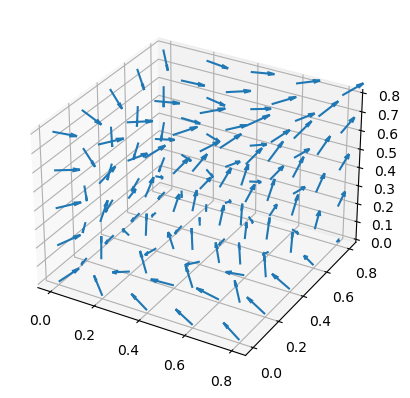

In [19]:
ax = plt.figure().add_subplot(projection='3d')


x = results['x'].reshape((5, 5, 5))
y = results['y'].reshape((5, 5, 5))
z = results['z'].reshape((5, 5, 5))
u = results['u'].reshape((5, 5, 5))
v = results['v'].reshape((5, 5, 5))
w = results['w'].reshape((5, 5, 5))

ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True)
plt.show()

In [20]:
#| export
def select_unique_values(data):
    """
    Selects a subset of unique values from the given array.

    If the number of unique values is greater than 10, it selects 5 evenly spaced values.

    Args:
    data (np.array): The input array from which to select unique values.

    Returns:
    np.array: An array of selected unique values.

    Example:
    >>> select_unique_values(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]))
    array([ 1,  3,  5,  7,  9, 11])
    """
    categories = data.unique()
    categories = categories[np.argsort(categories)]
    if len(categories) > 10:
        categories = categories[::len(categories)//5]
    return categories


In [21]:
#| export
def plot_generic_grid(df, x_col, y_col, data_col):
    """
    Plot a generic grid of subplots for the given data.
    
    Args:
    df (pd.DataFrame): The input DataFrame.
    x_col (str): The column name for the x-axis.
    y_col (str): The column name for the y-axis.
    data_col (str): The column name for the data to plot.
    
    Returns:
    fig (matplotlib.figure.Figure): The resulting figure.
    
    Notes:
    - The function will plot a grid of empty subplots for the given data. Plots
      can be added to the subplots later.
    - The given data in data_col should be numerical.
    - The data in x_col and y_col can be either numerical or categorical.
    - The x-axis will be labeled with unique values from the x_col. If there are
      more than 10 unique values, we show 5 evenly spaced values.
    - The y-axis will be labeled with unique values from the y_col. If there are
      more than 10 unique values, we show 5 evenly spaced values.
    """
    categories_x = select_unique_values(df[x_col])
    categories_y = select_unique_values(df[y_col])
    
    fig, axs = plt.subplots(len(categories_y), len(categories_x), figsize=(10, 10))

    hist_range = [df[data_col].min(), df[data_col].max()]
    for i, _ in enumerate(categories_y):
        for j, _ in enumerate(categories_x):
            # Skip drawing any plots for the time being
            # Customize x-axis ticks and labels
            # Remove bounding box
            for spine in axs[i, j].spines.values():
                spine.set_visible(False)
            axs[i, j].yaxis.set_visible(False)  # Hide y-axis  
            if i == 0 and j == 0:  # Top left subplot
                axs[i, j].set_xticks(hist_range)
                axs[i, j].set_xticklabels([f'{hist_range[0]:.2f}', f'{hist_range[1]:.2f}'])
            else:
                axs[i, j].set_xticks([])

    # Add labels at the top and left side of the overall plot
    i = 0
    for ax, col in zip(axs[0], categories_x):
        label = f"{col:.1f}" if isinstance(col, (int, float)) else col
        ax.annotate(f"{x_col}={label}" if i == 0 else f"{label}",
                    xy=(0.5, 1), xytext=(0, 15),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
        i+=1

    i = 0
    for ax, row in zip(axs[:, 0], categories_y):
        label = f"{row:.1f}" if isinstance(row, (int, float)) else row
        ax.annotate(f"{y_col}=\n{label}" if i == 0 else f"{label}",
                    xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='right', va='center')
        i += 1

    plt.subplots_adjust(wspace=0.5, hspace=0.2)  # Add more space between the histograms
    return fig, axs

In [27]:
#| export
def add_hists_to_grid(axs, df, x_col, y_col, data_col):
    """
    Add histogram plots to the grid of subplots in `axs`.
    
    Args:
    axs (np.array): An array of subplots.
    df (pd.DataFrame): The input DataFrame.
    x_col (str): The column name for the x-axis.
    y_col (str): The column name for the y-axis.
    data_col (str): The column name for the data to plot.
    
    Returns:
    np.array: An array of subplots with the added histogram plots.
    """
    categories_x = select_unique_values(df[x_col])
    categories_y = select_unique_values(df[y_col])
    
    hist_range = [df[data_col].min(), df[data_col].max()]
    for i, category_y in enumerate(categories_y):
        for j, category_x in enumerate(categories_x):
            data = df[(df[x_col] == category_x) & (df[y_col] == category_y)][data_col]
            color = "skyblue"
            axs[i, j].hist(data, bins=10, color = color, edgecolor='black', 
                           density=True, range=hist_range)
            
            
    return axs

def combine_duplicate_x_values(data, freq, tol=1e-6):
    """
    Combine duplicate x-values and sum their frequencies.
    
    Args:
    data (np.array): The input x-values.
    freq (np.array): The input frequencies.
    
    Returns:
    np.array: An array of combined x-values.
    np.array: An array of combined frequencies.
    """
    # First, we consider a tolerance for similar data points to be considered equal
    data = np.round(data, int(-np.log10(tol)))
    unique_data = np.unique(data)
    unique_freq = np.array([np.sum(freq[data == d]) for d in unique_data])
    return unique_data, unique_freq

def add_pdfs_to_grid(axs, df, x_col, y_col, data_col, freq_col):
    """
    Add pdf plots to the grid of subplots in `axs`.
    
    Args:
    axs (np.array): An array of subplots.
    df (pd.DataFrame): The input DataFrame.
    x_col (str): The column name for the x-axis.
    y_col (str): The column name for the y-axis.
    data_col (str): The column name for the data to plot.
    freq_col (str): The column name for the frequencies of the data values.
    
    Returns:
    np.array: An array of subplots with the added pdf plots.
    """
    categories_x = select_unique_values(df[x_col])
    categories_y = select_unique_values(df[y_col])
    
    hist_range = [df[data_col].min(), df[data_col].max()]
    hist_height = df[freq_col].max()
    for i, category_y in enumerate(categories_y):
        for j, category_x in enumerate(categories_x):
            data = df[(df[x_col] == category_x) & (df[y_col] == category_y)][data_col]
            freq = df[(df[x_col] == category_x) & (df[y_col] == category_y)][freq_col]
            # We need to combine any duplicate x-values and sum their frequencies
            data, freq = combine_duplicate_x_values(data, freq, tol=1e-6)
            
            color = "skyblue"
            axs[i, j].set_xlim(hist_range)  # Set the x-limits of the axes
            axs[i, j].set_ylim([0, hist_height])  # Set the y-limits of the axes
            
            # If there is no data for the given category, skip plotting
            if len(data) == 0:
                continue

            # Calculate the width of the bars based on the smallest difference between consecutive x-values
            sorted_data = np.sort(data)
            if len(data) > 1:
                min_diff = np.min(np.diff(sorted_data))
                bar_width = 0.8 * min_diff  # 0.8 is a common choice to leave some space between bars
                x_len = hist_range[1] - hist_range[0]
                # Clip the bar width to be between 1 and 10% of the x-axis length
                bar_width = np.clip(bar_width, 0.01 * x_len, 0.1 * x_len)
            else:
                bar_width = 0.5
            
            axs[i, j].bar(data, freq, color = color, width=bar_width)
            # Add back in x_axis spine which vanishes when plotting bar plots
            # in some cases
            axs[i, j].spines['bottom'].set_visible(True)
            axs[i, j].spines['bottom'].set_linewidth(0.5)
            
    return axs

In [28]:
#| export
def test_add_pdfs_to_grid():
    # Create a DataFrame with some dummy data
    mu = 0
    sigma = 1
    M = 500
    x_values =  np.random.normal(mu, sigma, M)
    pdf_values = (1 / (np.sqrt(2 * np.pi * sigma**2))) * np.exp(- (x_values - mu)**2 / (2 * sigma**2))
    df = pandas.DataFrame({
        'x_col': np.random.choice(['A', 'B', 'C'], M),
        'y_col': np.random.choice(['X', 'Y', 'Z'], M),
        #  This time we should have a normal distribution
        'data_col': x_values,
        # Each freq value should be between 1 and 0 and add up to 1
        'freq_col': pdf_values,
    })

    # Call setup_grid to get the grid of subplots
    fig, axs = plot_generic_grid(df, 'x_col', 'y_col', 'data_col')

    # Call add_pdfs_to_grid
    axs = add_pdfs_to_grid(axs, df, 'x_col', 'y_col', 'data_col', 'freq_col')

    # Check that the x-limits of each subplot are the same
    xlims = [ax.get_xlim() for ax in fig.axes]
    assert all(xlim == xlims[0] for xlim in xlims)
    
    # Check that each subplot has a bar plot if M is high (not guaranteed)
    for ax in fig.axes:
        if M > 200:
            assert len(ax.patches) > 0

In [29]:

#| export
def test_add_hists_to_grid():
    # Create a DataFrame with some dummy data
    df = pandas.DataFrame({
        'x_col': np.random.choice(['A', 'B', 'C'], 100),
        'y_col': np.random.choice(['X', 'Y', 'Z'], 100),
        'data_col': np.random.normal(0, 1, 100),
    })

    # Call setup_grid to get the grid of subplots
    fig, axs = plot_generic_grid(df, 'x_col', 'y_col', 'data_col')

    # Call add_pdfs_to_grid
    axs = add_hists_to_grid(axs, df, 'x_col', 'y_col', 'data_col')

    # Check that each subplot has a bar plot
    for ax in fig.axes:
        assert len(ax.patches) > 0

    # Check that the x-limits of each subplot are the same
    xlims = [ax.get_xlim() for ax in fig.axes]
    assert all(xlim == xlims[0] for xlim in xlims)


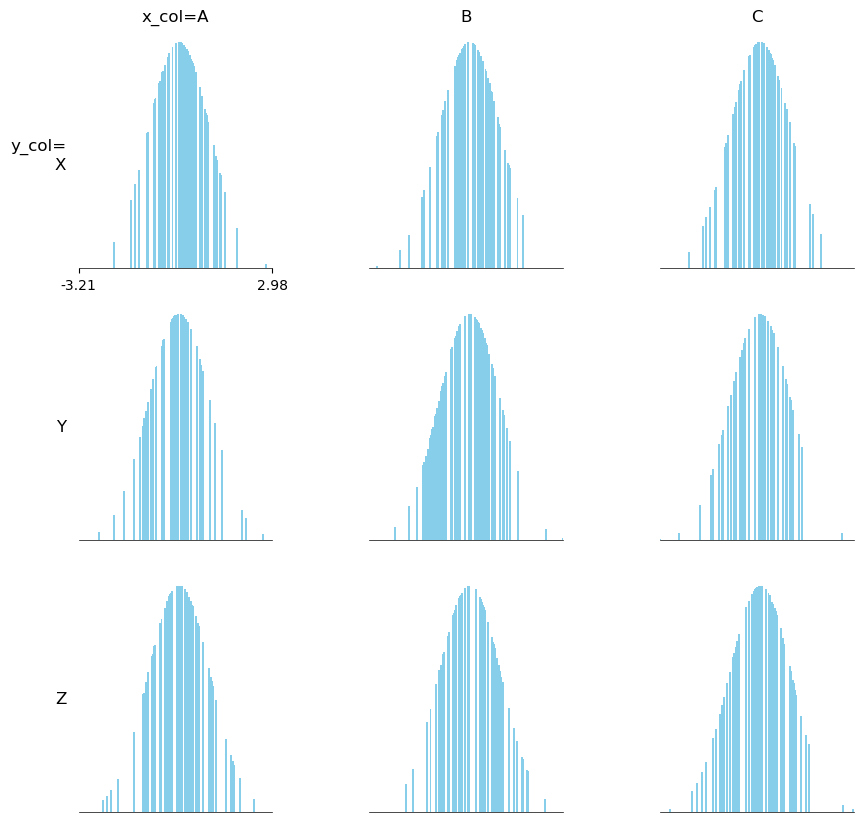

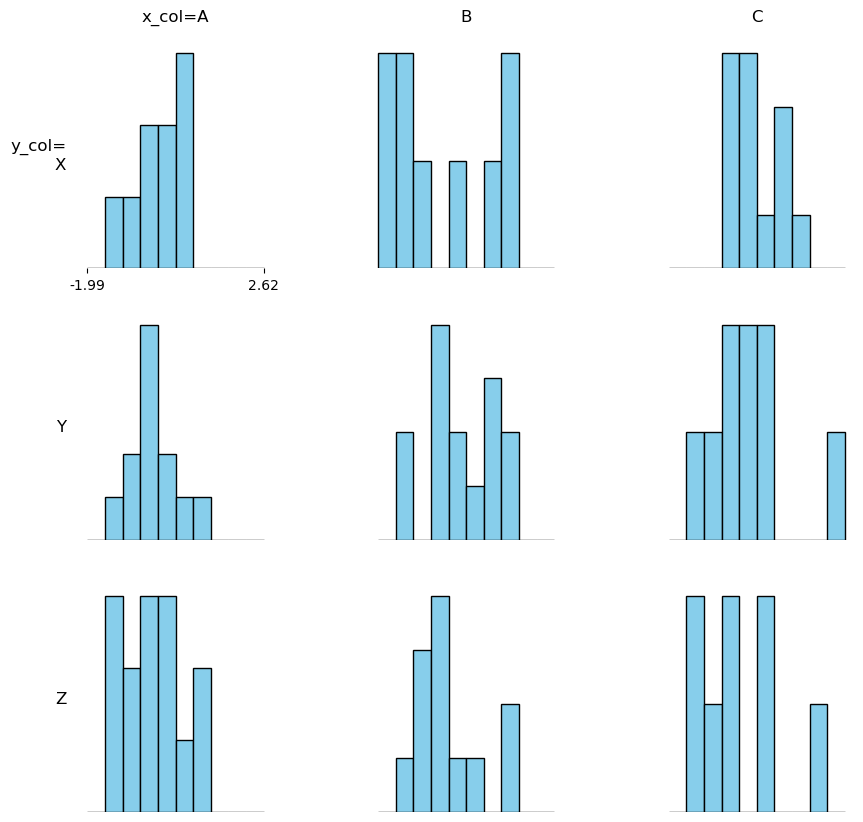

In [30]:
test_add_pdfs_to_grid()
test_add_hists_to_grid()

In [26]:
#| hide
import nbdev; nbdev.nbdev_export()